In [1]:
import re

import pandas as pd
import numpy as np
import seaborn as sns

from math import sin, cos, sqrt, atan2, radians
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer

import lightgbm as lgb
from xgboost import XGBRegressor
from catboost import Pool, CatBoostRegressor, cv

from sklearn.model_selection import train_test_split

In [2]:
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [3]:
street_types = ("тракт", "шоссе", "улица", "проспект", "набережная", "бульвар", "проезд", "аллея", "линия", "площадь",
                "переулок", "автодорога", "Малый проспект", "Средний проспект", "Большой проспект",
                "болото", "река", "р.", "озеро", "остров", "МКАД")

short_street_types = ("ул.", "наб.", "пр.", "просп.", "линия", "пер.", "шоссе", "пл.")

remove_natasha_types = ("область", "офис")

settlement_types = ("поселок городского типа",
                    "поселок подсобного хозяйства",
                    "городской поселок",
                    "городское поселение",
                    "коттеджный поселок",
                    "станица",
                    "деревня",
                    "хутор",
                    "урочище",
                    "сельское поселение",
                    "садовое товарищество",
                    "садовые участки",
                    "садоводческое некоммерческое товарищество",
                    "дачный поселок",
                    "рабочий поселок",
                    "поселок",
                    "поселение",
                    "село",
                    "город ",
                    "жилой массив",
                    "муниципальное образование Город",
                    "г. ", "рабочий пос.", "пос. ", "с. ", "пгт. ",
                    "СТ", )
upper_region_types = ("автономный округ", "Республика", "республика", "край", "область", )
other_useful_types = ("городской округ", "административный округ",
                      "муниципальный район",
                      "территориальный округ",
                      "исторический район",
                      "жилой район", "территория", "планировочный район", "район",
                      "метро",
                      "жилой квартал",
                      "Особая экономическая зона",
                      "СНТ",
                      "аэропорт",
                      "жилой комплекс",
                      "индустриальный парк",
                      "квартал",
                     )


def parse_street_for_nominatim(street):
    street = street.split()
    street = " ".join([w for w in street
                       if len(w) > 1 and not w.endswith(".")])
    street = re.split("\.", street)
    street = " ".join([w for w in street
                       if len(w) > 1 and not w.endswith(".")])
    return street


def replace_address_type(address, address_types):
    for t in address_types:
        address = address.replace(t, "")
    return address


def my_extractor(address):
    if not address:
        return "", "", "", ""
    city = ""
    settlement_type = ""
    street = ""
    house_number = ""
    region = ""
    upper_region = ""
    upper_region_type = ""
    street_type = ""
    building = ""
    house_litera = False
    house_fraction = False
    corpus = ""
    index = ""
    address = re.sub("^\d{6},", "", address).strip()
    address = address.split(", ")

    for a_i, a in enumerate(address):
        if a == "Россия":
            continue
        elif "микрорайон" in a:
            continue
        elif a.startswith(settlement_types) or a.endswith(settlement_types):
            settlement_type = [t for t in settlement_types if t in a][0]
            city = replace_address_type(a, settlement_types)
        elif a.endswith(upper_region_types) or a.startswith(upper_region_types):
            upper_region_type = [r for r in upper_region_types if r in a][0]
            upper_region = replace_address_type(a, upper_region_types)
        elif a.endswith(other_useful_types) or a.startswith(other_useful_types):
            region = replace_address_type(a, other_useful_types)
        elif a.startswith(short_street_types):
            a = replace_address_type(a, short_street_types)
            a = parse_street_for_nominatim(a)
            street = a
        elif a.endswith(street_types) or a.startswith(street_types):
            street_type = [s for s in street_types if s in a][0]
            a = replace_address_type(a, street_types)
            a = parse_street_for_nominatim(a)
            street = a
        elif (re.findall("\d+", a) or a_i == len(address) - 1):
            found_number = re.findall("д. \d+", a)
            if not found_number:
                found_number = re.findall("^\d+", a)
            if found_number:
                found_number = found_number[0]
                if len(found_number) == 6:
                    index = found_number
                else:
                    if re.findall("[А-Яа-я]", a):
                        house_litera = True
                    if "/" in a:
                        house_fraction = True
                    house_number = found_number.replace("д. ", "")
        else:
            if not city:
                city = a
                settlement_type = "город"
    return (upper_region.strip(), region.strip(), city.strip(), street.strip(), house_number.strip(), index,
            street_type, upper_region_type, settlement_type, house_litera, house_fraction)

R = 6373.0 # радиус земли в километрах
def distance(x,y):
    """
    Параметры
    ----------
    x : tuple, широта и долгота первой геокоординаты 
    y : tuple, широта и долгота второй геокоординаты 
    
    Результат
    ----------
    result : дистанция в километрах между двумя геокоординатами
    """
    lat_a, long_a, lat_b, long_b = map(radians, [*x,*y])    
    dlon = long_b - long_a
    dlat = lat_b - lat_a
    a = sin(dlat/2)**2 + cos(lat_a) * cos(lat_b) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

def spherical_dist(pos1, pos2, r=3958.75):
    pos1 = pos1 * np.pi / 180
    pos2 = pos2 * np.pi / 180
    cos_lat1 = np.cos(pos1[..., 0])
    cos_lat2 = np.cos(pos2[..., 0])
    cos_lat_d = np.cos(pos1[..., 0] - pos2[..., 0])
    cos_lon_d = np.cos(pos1[..., 1] - pos2[..., 1])
    return r * np.arccos(cos_lat_d - cos_lat1 * cos_lat2 * (1 - cos_lon_d))

import pandas as pd
import requests
import logging
import time

def get_google_results(address, api_key=None, return_full_response=False):
    """
    Get geocode results from Google Maps Geocoding API.
    
    Note, that in the case of multiple google geocode reuslts, this function returns details of the FIRST result.
    
    @param address: String address as accurate as possible. For Example "18 Grafton Street, Dublin, Ireland"
    @param api_key: String API key if present from google. 
                    If supplied, requests will use your allowance from the Google API. If not, you
                    will be limited to the free usage of 2500 requests per day.
    @param return_full_response: Boolean to indicate if you'd like to return the full response from google. This
                    is useful if you'd like additional location details for storage or parsing later.
    """
    # Set up your Geocoding url
    geocode_url = "https://maps.googleapis.com/maps/api/geocode/json?address={}".format(address)
    if api_key is not None:
        geocode_url = geocode_url + "&key={}".format(api_key)
        
    # Ping google for the reuslts:
    results = requests.get(geocode_url)
    # Results will be in JSON format - convert to dict using requests functionality
    results = results.json()
    
    # if there's no results or an error, return empty results.
    if len(results['results']) == 0:
        output = {
            "formatted_address" : None,
            "latitude": None,
            "longitude": None,
            "accuracy": None,
            "google_place_id": None,
            "type": None,
            "postcode": None
        }
    else:    
        answer = results['results'][0]
        output = {
            "formatted_address" : answer.get('formatted_address'),
            "latitude": answer.get('geometry').get('location').get('lat'),
            "longitude": answer.get('geometry').get('location').get('lng'),
            "accuracy": answer.get('geometry').get('location_type'),
            "google_place_id": answer.get("place_id"),
            "type": ",".join(answer.get('types')),
            "postcode": ",".join([x['long_name'] for x in answer.get('address_components') 
                                  if 'postal_code' in x.get('types')])
        }
        
    # Append some other details:    
    output['input_string'] = address
    output['number_of_results'] = len(results['results'])
    output['status'] = results.get('status')
    if return_full_response is True:
        output['response'] = results
    
    return output

def split_city(df_row):
    map_firct_ch = {
        32: 23,
        496: 26,
        1022: 26,
        1942: 26,
        3185: 26,
        5478: 26,
        8083: 23
    }
    if df_row["atm_group"] in map_firct_ch.keys():
        return df_row["address"][map_firct_ch[df_row["atm_group"]]:].strip().upper()
    else:
        return df_row["address"]

In [4]:
# base_address = "http://127.0.0.1:8081/nominatim/reverse.php?accept-language=ru&format=json"&lat=55.755814&lon=37.617635&zoom=18
# def reverse_search(latitude, longitude):
    

In [5]:
train = pd.read_csv('train.csv', index_col=0)

In [6]:
# train["lat"] = latitudes[:train.shape[0]]
# train["long"] = longitudes[:train.shape[0]]
# train.to_csv("train.csv")

In [7]:
test = pd.read_csv('test.csv', index_col=0)

In [8]:
# test["lat"] = latitudes[train.shape[0]:]
# test["long"] = longitudes[train.shape[0]:]
# test.to_csv("test.csv")

In [9]:
train['isTrain'] = True
test['isTrain'] = False

In [10]:
X = train.append(test, sort=False)

In [11]:
X["rounded_id"] = round(X["id"] / 500)

In [12]:
X["atm_group_float"] = X["atm_group"] - (X["atm_group"].astype(int))

In [13]:
# X["address"]

In [14]:
# z = get_google_results("KOMMUN. PR., 32        YUZHNO SAKHAL")

In [15]:
# z

In [16]:
# import geocoder
# for address_i, address in enumerate(X["address"].values):
#     if address_i < len(arcgis_values):
#         continue
#     arcgis = geocoder.arcgis(address)
#     arcgis_values.append(arcgis)
#     print(" " * 100, end="\r")
#     print(address_i, address, arcgis, end="\r")

In [17]:
# X[pd.isna(X["address_rus"]) & pd.notna(X["long"])][["id", "lat", "long"]]

### Загрузка нормализованных городов и данных о населении и тд

In [18]:
# X_2 = pd.read_csv('000.csv', index_col=0)
X["atm_group"] = X["atm_group"].astype(int)
X["city_split"] = X.apply(split_city, axis=1)

X_2 = pd.read_csv('df_main.csv', index_col=0)
print(X.shape, X_2.shape)
X = pd.merge(X, X_2, how='left', left_on='city_split', right_on='place_city_en')


(8765, 11) (1312, 24)


In [19]:
# X_2 = X_2.drop(["atm_group", "address", "address_rus", "lat", "target", "train", "lon"], axis=1)
# X_2 = X_2.drop(["min_atm_group", "max_atm_group", "mean_atm_group", "median_atm_group", "std_atm_group"], axis=1)
# X_2 = X_2.drop(["min_place_city", "max_place_city", "mean_place_city", "median_place_city", "std_place_city",
#                 "count_place_region", "min_place_region", "max_place_region", "mean_place_region",
#                 "median_place_region", "std_place_region", "min_global", "max_global", "mean_global",
#                 "median_global", "std_global"], axis=1)
# X_2.rename(columns={'city': 'city_eng'}, inplace=True)
# X_2 = X_2.drop_duplicates()
# X_2["place_fo"] = X_2["place_fo"].fillna("None")

In [20]:
# X = pd.merge(X, X_2, how='left', on='id')

In [21]:
# X_2.columns

### Загрузка данных от PCA

In [22]:
X_2 = pd.read_csv('pca.csv')
X_2 = X_2.drop('target', 1)
X = pd.merge(X, X_2, left_index=True, right_index=True)

### Загрузка данных из OSM о типе здания

In [23]:
X_2 = pd.read_csv('osm_addresses.csv', index_col=0)
X_2 = X_2[["id", "osm_type", "osm_category"]]
X = pd.merge(X, X_2, how='left', on='id')

### Триграммы

In [24]:
# n = 3
# trigrams  = [" ".join([sent[i : i + n] for i in range(len(sent) - n + 1)]) for sent in X["address"].values]
# vectorizer = CountVectorizer()
# trigrams = vectorizer.fit_transform(trigrams)
# trigrams_df = pd.DataFrame(trigrams.toarray(), columns=vectorizer.get_feature_names(), index=X.index)

In [25]:
# X = pd.merge(X, trigrams_df, left_index=True, right_index=True, suffixes=("", "trigram"))

### Таргет для ближайших id

In [26]:
# Ищем ближайшие айди, у которых есть таргеты

targets = X[X["isTrain"]][["id", "target"]]
ids = X["id"]
target_ids = targets["id"].values
targets = targets["target"].values
for n in (2, 3, 5, 10, 50):
    closest_targets = [np.average(targets[np.argsort(np.abs(ids[i] - target_ids))[1:n]]) for i in range(ids.shape[0])]
    X["closest_{}_ids_target".format(n)] = np.array(closest_targets)
    X["closest_{}_ids_tgt_corr_by_ind".format(n)] = np.array(closest_targets) /\
        np.array([np.sum([np.sort(np.abs(ids[i] - target_ids))[1:n]]) for i in range(ids.shape[0])])

In [27]:
atm_groups = X[X["isTrain"]]["atm_group"].values
ids = X[X["isTrain"]]["id"].values
group_id = 0
group_ids = {0: [ids[0]]}

for i in range(1, len(ids)):
    if atm_groups[i] == atm_groups[i - 1] and abs(ids[i] - ids[i - 1]) <= 50:
        group_ids[group_id].append(ids[i])
    else:
        group_id += 1
        group_ids[group_id] = [ids[i]]
print(len(group_ids))
group_ids = {k: v for k, v in group_ids.items() if len(v) > 2}
print(len(group_ids))
groups_ids_averaged = np.array([np.mean(v) for v in group_ids.values()])
closest_groups = [np.argmin(np.abs(X["id"].values[i] - groups_ids_averaged)) for i in range(X.shape[0])]
closest_groups = np.array(closest_groups)
X["closest_groups"] = closest_groups
# np.argmin(np.abs(X["id"].values[4] - groups_ids_averaged))

213
121


In [28]:
rosbank = train[train["atm_group"] == 8083.0]
print(rosbank.columns)
rosbank["lat"] = rosbank["lat"].fillna(0)
rosbank["long"] = rosbank["long"].fillna(0)
targets = rosbank["target"].values
ids = rosbank["id"].values
mask = np.argsort(ids)
targets = targets[mask]


Index(['id', 'atm_group', 'address', 'address_rus', 'lat', 'long', 'target',
       'isTrain'],
      dtype='object')


/home/denis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/denis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [29]:
prev_targets = np.zeros(shape=rosbank["id"].shape[0])
prev_targets[1:] = np.subtract(targets[1:], targets[:-1])

rosbank["prev_target"] = pd.Series(prev_targets, index=rosbank.index[mask])

/home/denis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


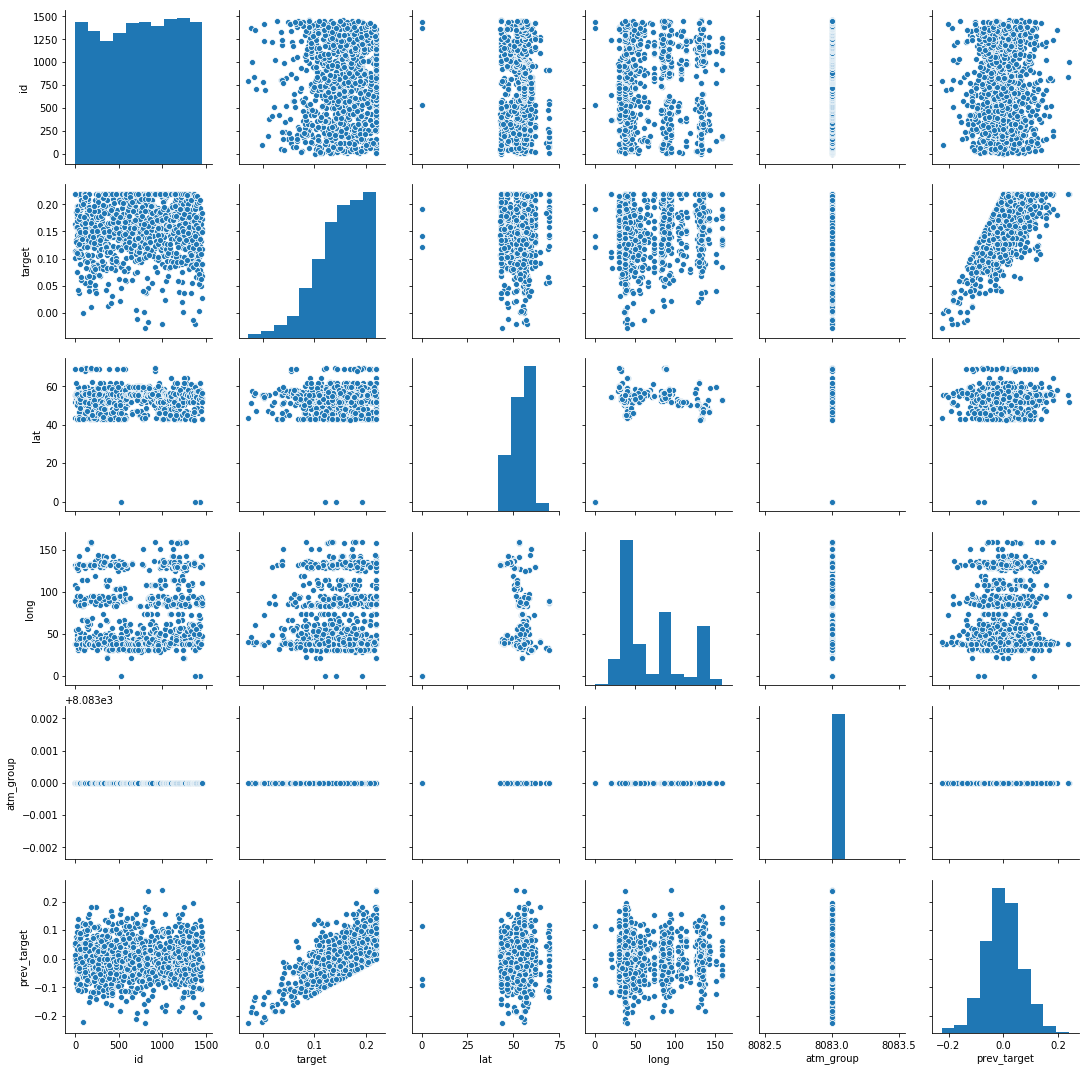

In [30]:
rosbank = rosbank[["id", "target", "lat", "long", "atm_group", "prev_target"]]
rosbank["id"] = rosbank["id"] - rosbank["id"].min()
# rosbank["target"] = rosbank["target"] * 10000
%matplotlib inline
sns.pairplot(rosbank)

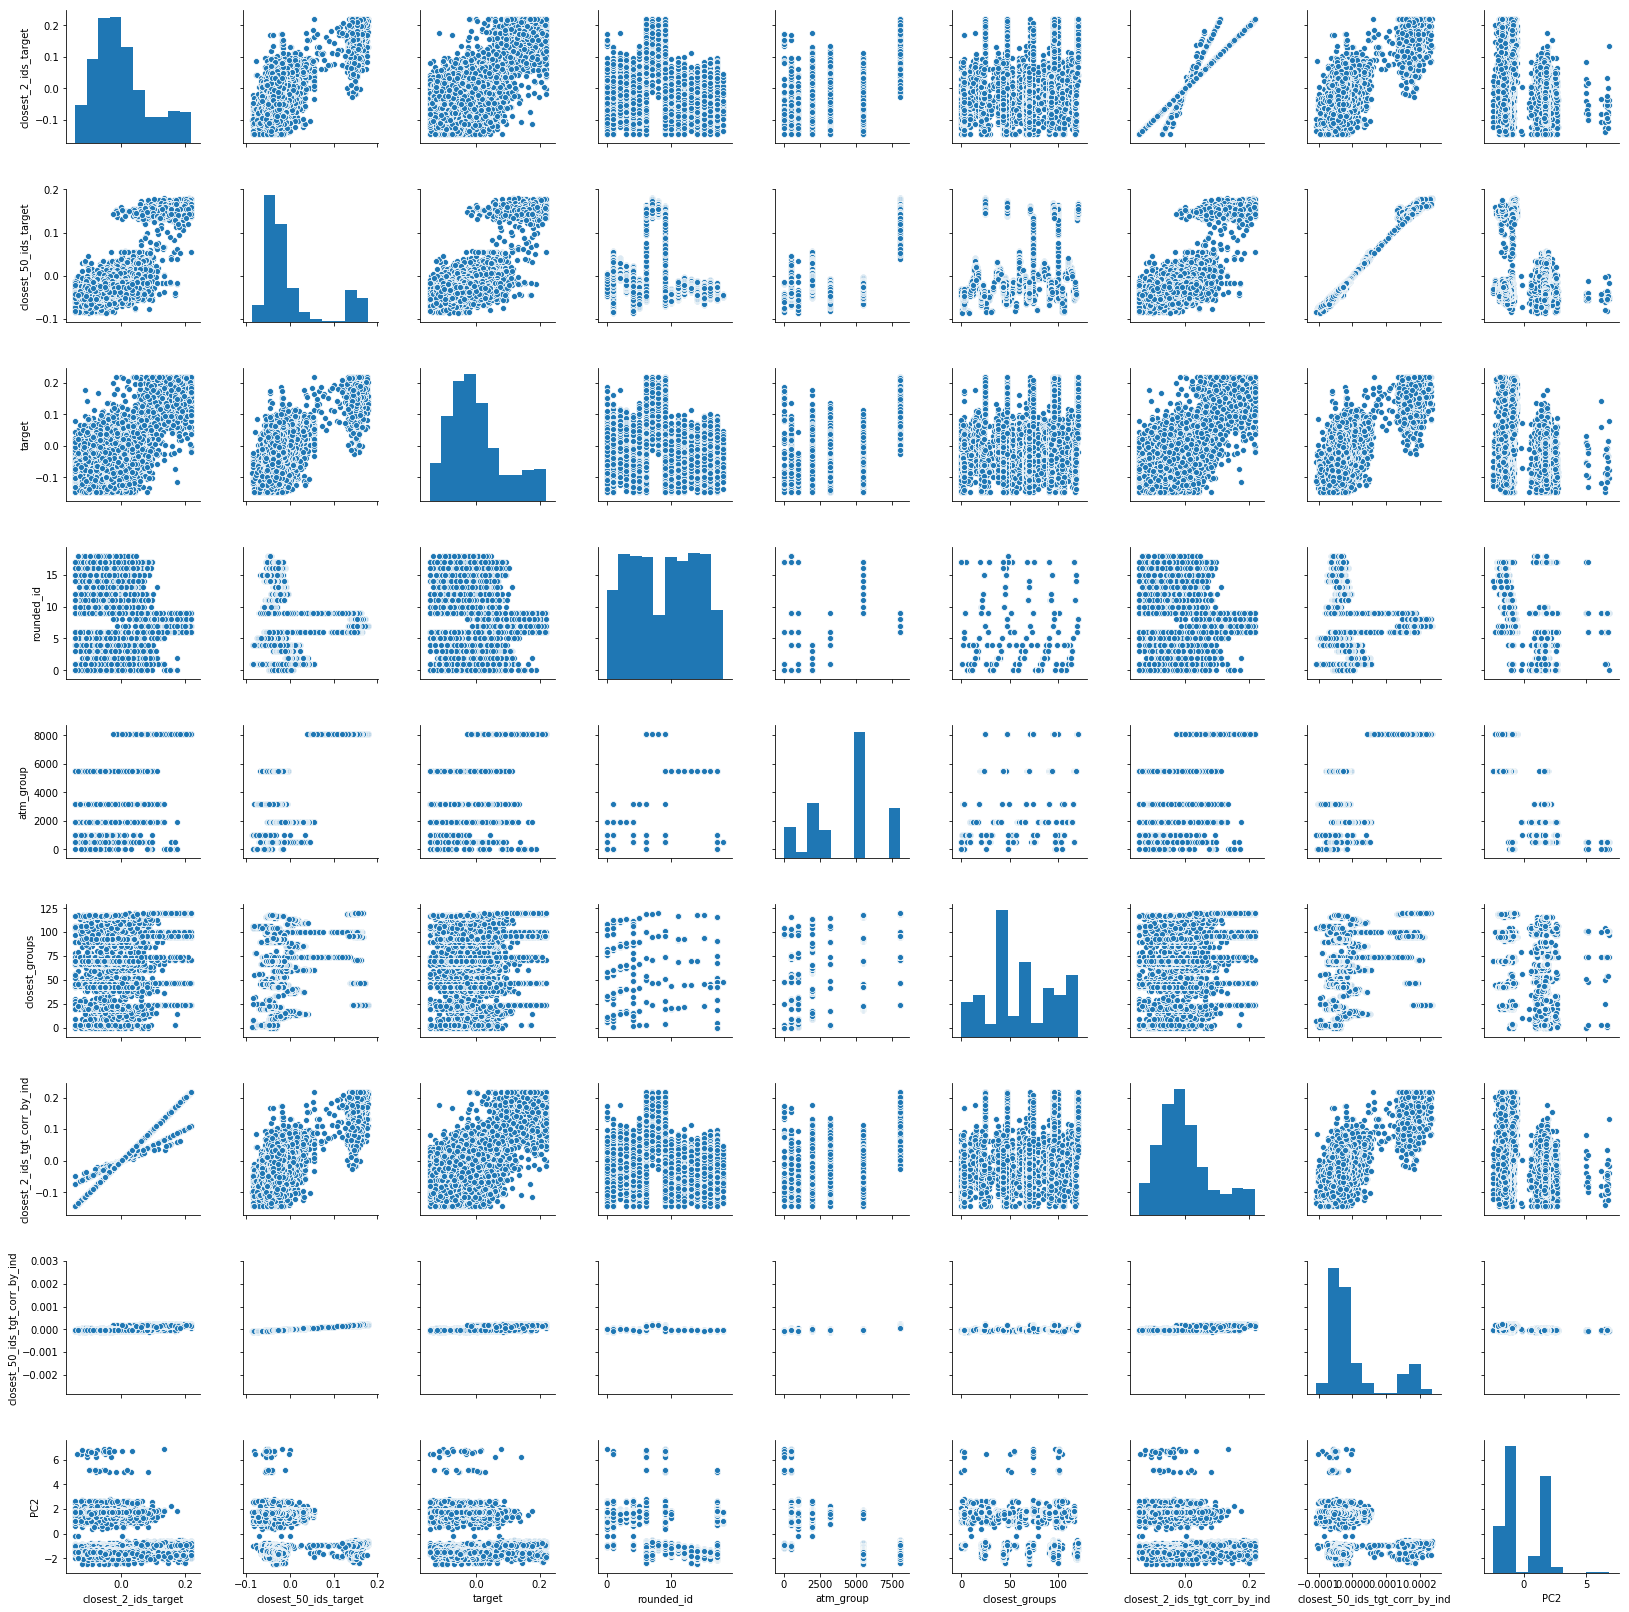

In [31]:
sns.pairplot(X[X["isTrain"]][["closest_2_ids_target", "closest_50_ids_target", "target", "rounded_id", "atm_group",
                              "closest_groups",
                              "closest_2_ids_tgt_corr_by_ind", "closest_50_ids_tgt_corr_by_ind", "PC2"]])

###### X.describe().T

In [32]:
X.describe(include='object').T

,count,unique,top,freq
address,8765,7481,"HOROSHEVSKOE SH,V38 MOSKVA",7
address_rus,8345,6147,"квартал В-13, городской округ Волгодонск, Рост...",10
city_split,8765,1312,MOSCOW,416
place_city,8765,911,Москва,887
place_region,8765,80,Москва,904
place_city_en,8765,1312,MOSCOW,416
osm_type,5957,121,yes,3509
osm_category,5957,13,building,3496


### Количество банкоматов стоящих по одному адресу

In [33]:
X["address_rus"] = X["address_rus"].str.replace("ё", "е")
counts = X.groupby('address_rus')['id'].count().reset_index().rename(columns={'id':'count'})

In [34]:
X = pd.merge(X, counts, how='left', on='address_rus')

In [35]:
X.tail()

,id,atm_group,address,address_rus,lat,long,target,isTrain,rounded_id,atm_group_float,...,closest_3_ids_target,closest_3_ids_tgt_corr_by_ind,closest_5_ids_target,closest_5_ids_tgt_corr_by_ind,closest_10_ids_target,closest_10_ids_tgt_corr_by_ind,closest_50_ids_target,closest_50_ids_tgt_corr_by_ind,closest_groups,count
8760,7805.0,5478,"D. 12, PROEZD ZAREVYI MOSKVA G","Заревый проезд, 12, Москва, Россия, 127282",55.886488,37.656829,NaN,False,16.0,0.0,...,-0.062815,-0.015704,-0.012503,-0.001137,-0.009959,-0.000262,-0.023157,-0.000028,46,1.0
8761,7395.0,5478,"D. 2B, UL. MIRA SOCHI G","улица Мира, 4, Адлерский район, Сочи, Краснода...",43.438310,39.912211,NaN,False,15.0,0.0,...,-0.035175,-0.008794,-0.057305,-0.004775,-0.067564,-0.001609,-0.053420,-0.000056,46,1.0
8762,3339.0,8083,"KARMANITSKIY, 9 Moskva","Карманицкий переулок, 9, Москва, Россия, 119002",55.748275,37.583571,NaN,False,7.0,0.0,...,0.093457,0.031152,0.096788,0.012098,0.115848,0.003737,0.137014,0.000153,119,2.0
8763,675.0,1942,3A SHARAPOVSKIY WAY MYTISHCHI,"Шараповская улица, 1, Мытищи, Московская облас...",55.910992,37.748466,NaN,False,1.0,0.0,...,0.071180,0.010169,0.041912,0.002620,0.034238,0.000728,0.052990,0.000052,60,5.0
8764,3135.0,8083,"24 KM MKAD, VLADENIE 1 Moskva","МКАД, 24-й километр, 1, Москва, Россия",55.586807,37.724966,NaN,False,6.0,0.0,...,0.122490,0.030622,0.142082,0.014208,0.158683,0.004176,0.145093,0.000162,119,1.0


### Расстояния до ближайших банкоматов

In [36]:
# knc = KNeighborsClassifier(metric=distance)
# neighbours_n = 2

In [37]:
# dots = X[['lat','long']].dropna()

In [38]:
# knc.fit(X=dots , y=np.ones(dots.shape[0]))

In [39]:
# distances, indexes = knc.kneighbors(X=dots,n_neighbors=neighbours_n,)

In [40]:
# for i in range(1,neighbours_n):
#     dots['distance_%s'%i] = distances[:,i]
#     dots['indexes_%s'%i] = indexes[:,i]

In [41]:
# dots['mean'] = dots.iloc[:,dots.columns.str.contains('distance')].mean(axis=1)

In [42]:
# dots = dots.drop("lat", 1)
# dots = dots.drop("long", 1)


In [43]:
# X = pd.concat([X,dots], axis=1)

### Средний по широте и долготе

In [44]:
X["lat_round"] = round(X["lat"] / 3).fillna(0)
X["long_round"] = round(X["long"] / 3).fillna(0)

In [45]:
X["long_round"].shape

(8765,)

In [46]:
X["mean_target_lat"] = X.groupby("lat_round").transform("mean")["target"]
X["median_target_lat"] = X.groupby("lat_round").transform("median")["target"]
# X["min_target_lat"] = X.groupby("lat_round").transform("min")["target"]
# X["max_target_lat"] = X.groupby("lat_round").transform("max")["target"]
X["count_target_lat"] = X.groupby("lat_round").transform("count")["count"]

X["mean_target_long"] = X.groupby("long_round").transform("mean")["target"]
X["median_target_long"] = X.groupby("long_round").transform("median")["target"]
# X["min_target_long"] = X.groupby("long_round").transform("min")["target"]
# X["max_target_long"] = X.groupby("long_round").transform("max")["target"]
X["count_target_long"] = X.groupby("long_round").transform("count")["count"]

/home/denis/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/denis/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/denis/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


### Средний таргет по атм_груп

In [47]:
X["mean_target_atm"] = X.groupby("atm_group").transform("mean")["target"]
X["median_target_atm"] = X.groupby("atm_group").transform("median")["target"]
X["min_target_atm"] = X.groupby("atm_group").transform("min")["target"]
X["max_target_atm"] = X.groupby("atm_group").transform("max")["target"]
X["count_target_atm"] = X.groupby("atm_group").transform("count")["count"]

### Расстояние до [Кремля, Ханты-Мансийска, Новосибирска, Владивостока]

In [48]:
kremlin_coords = [55.7520, 37.6175]
hanty_coords = [61.0091, 69.0375]
novosibirsk_coords = [55.0084, 82.9357]
vladivostok_coords = [43.1198, 131.8869]

X["distance_to_kremlin"] = spherical_dist(X[["lat", "long"]].values, np.array(kremlin_coords))
X["distance_to_hanty"] = spherical_dist(X[["lat", "long"]].values, np.array(hanty_coords))
X["distance_to_novosibirsk"] = spherical_dist(X[["lat", "long"]].values, np.array(novosibirsk_coords))
X["distance_to_vladivostok"] = spherical_dist(X[["lat", "long"]].values, np.array(vladivostok_coords))

### Количество ближайших банкоматов

In [49]:
# Матрица расстояний
distance_matrix = np.zeros(shape=[X.shape[0], X.shape[0]])
for i in range(X.shape[0]):
    distances =  spherical_dist(X[["lat", "long"]].values, X[["lat", "long"]].values[i])
    # расстояние до самого себя
    distances[i] = 100000
    distance_matrix[i] = distances

### Количество [любых, не из того же адреса, той же atm_group, Росбанка] банкоматов в 100, 500, 1000, 10000 метрах

In [50]:
# в километрах
distance_values = [0.1, 0.5, 1, 10]
conditions = ["any", "not_same_address", "same_atm_group", "rosbank"]
for condition in conditions:
    for distance_value in distance_values:
        print(condition, distance_value)
        atm_count = np.sum(distance_matrix < distance_value, axis=0)
        column_name = "{}_{}".format(condition, distance_value)
        if condition == "any":
            mask = np.array([False] * atm_count.shape[0])
        elif condition == "not_same_address":
            mask = X["address_rus"] == X["address_rus"].values[i]
        elif condition == "same_atm_group":
            mask = X["atm_group"] != X["atm_group"].values[i]
        elif condition == "rosbank":
            mask = X["atm_group"] != 8083.0
        atm_count[mask] = -1
        X[column_name] = atm_count

any 0.1
any 0.5


/home/denis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys


any 1
any 10
not_same_address 0.1
not_same_address 0.5
not_same_address 1
not_same_address 10
same_atm_group 0.1
same_atm_group 0.5
same_atm_group 1
same_atm_group 10
rosbank 0.1
rosbank 0.5
rosbank 1
rosbank 10


### Город размещения

In [51]:
address = X['address_rus'].fillna('').values
parsed_address = [my_extractor(a) for a in address]

columns = ["upper_region", "region", "city", "street", "house_number", "index",
            "street_type", "upper_region_type", "settlement_type", "house_litera", "house_fraction"]
parsed_address_dicts = [dict(zip(columns, p)) for p in parsed_address]

In [52]:
address_df = pd.DataFrame(parsed_address_dicts, index = X.index)

In [53]:
X = pd.merge(X, address_df, left_index=True, right_index=True)

In [54]:
good_columns = []
for c in X.columns:
    try:
        col_type = X[c].dtype
        good_columns.append(c)
    except:
        continue
    if col_type == 'object' or col_type.name == 'category':
        X[c] = X[c].astype('category')

In [55]:
Y_ = X.loc[X.isTrain, 'target']

In [56]:
X["house_number"] = X["house_number"].replace(r'\s+', "0", regex=True).replace('', "0").fillna(0)
X['house_number'] = X['house_number'].astype(int).fillna(-1)

In [57]:
X['house_number_even'] = (X['house_number'] % 2 == 0) & (X['house_number'] > 0)

In [58]:
X["is_city"] = (X["settlement_type"] == "город") | (X["settlement_type"] == "муниципальное образование Город")

### Банкоматов в городе [всего, по атм_груп]

In [59]:
X["atms_by_city"] = X.groupby("city").transform("count")["id"]

In [60]:
atm_groups = pd.unique(X["atm_group"])

for atm in atm_groups:
    print(atm)
    mask = X["atm_group"] != atm
    column = "atm_{}_by_city".format(int(atm))
    atm_count[mask] = 0
    column_values = np.zeros(shape=X.shape[0])
    column_update = X[X["atm_group"] == atm].groupby("city").transform("count")["id"]
    column_values[column_update.index] = column_update
    X[column] = column_values
    

32
496
1022
1942
3185
5478
8083


### Фильтр таргета по колонкам

In [61]:
# "place_fo"
for column in ["city", "upper_region", "region", "place_city_en", "place_city", "place_region", "house_number",
               "street", "street_type",
               "index"]:
    rare_values = X[column].value_counts()[(X[column].value_counts() < 20) ==True].index
    X[column] = X[column].apply(lambda x: 'RARE' if x in rare_values else x)
    X[column] = X[column].astype('category')

### Значения таргета по разным колонкам

In [62]:
# "place_fo"
functions = ["median", "mean", "min", "max", "count"]
for column in ["city", "upper_region", "place_city_en", "place_city", "place_region",
               "rounded_id", "closest_groups"]:
    # X[column] = X[column].fillna(-1)
    for function in functions:
        print(column, function)
        try:
            X["{}_target_{}".format(function, column)] = X.groupby(column).transform(function)["target"]
        except TypeError:
            print("Exception")

city median
city mean
city min
city max
city count
upper_region median
upper_region mean
upper_region min
upper_region max
upper_region count
place_city_en median
place_city_en mean
place_city_en min
place_city_en max
place_city_en count
place_city median
place_city mean
place_city min
place_city max
place_city count
place_region median
place_region mean
place_region min
place_region max
place_region count
rounded_id median
rounded_id mean
rounded_id min
rounded_id max
rounded_id count
closest_groups median
closest_groups mean
closest_groups min
closest_groups max
closest_groups count


In [63]:
# sns_plot = sns.pairplot(X[X["isTrain"]], size=2.5)
# fig = swarm_plot.get_figure()
# fig.savefig("pairplot.png") 

In [64]:
X = X.drop('target', 1)
X = X.drop('id', 1)
X = X.drop('address', 1)
X = X.drop('address_rus', 1)

In [65]:
categorical = X.select_dtypes(['category']).columns
X[categorical] = X[categorical].apply(lambda x: x.cat.codes)

In [66]:
X_ = X[X.isTrain.astype(bool)]
X_test = X[~X.isTrain.astype(bool)]

In [67]:
X_, X_valid_final, Y_, Y_valid_final = train_test_split(X_, Y_, test_size=0.1, random_state=42)

In [68]:
def train_lgb(X_train, Y_train, X_valid, Y_valid):
    gbm = lgb.LGBMRegressor(objective = 'regression',  
                            max_depth = 8,
                            num_leaves = 240,
                            colsample_bytre = 0.8,
                            subsample = 0.8, 
                            learning_rate = 0.01,
                            n_estimators = 500, )
    gbm.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)], eval_metric='rmse', early_stopping_rounds=5, verbose=0)
    %matplotlib inline
    ax = lgb.plot_importance(gbm)
    fig = ax.figure
    fig.set_size_inches(20, 20)
    score = rmse(Y_valid, gbm.predict(X_valid))
    print("lgb", score)
    return gbm, score

### XGBoost

In [69]:
def train_xgb(X_train, Y_train, X_valid, Y_valid):
    xgb = XGBRegressor(seed=42, n_estimators=150, max_depth = 5, early_stopping_rounds=5, verbose=50, verbose_eval=False)
    xgb.fit(X_train, Y_train,
            eval_set=[(X_valid, Y_valid)],
            verbose=75)
    score = rmse(Y_valid, xgb.predict(X_valid))
    pd.DataFrame(list(zip(X_train.columns, xgb.feature_importances_)), columns=["Feature", "Score"]).sort_values(
                 "Score", ascending=False)
    return xgb, score

### Catboost

In [70]:
def train_cat(X_train, Y_train, X_valid, Y_valid):
    # initialize Pool
    train_pool = Pool(X_train, Y_train)
    valid_pool = Pool(X_valid)
    # specify the training parameters 
    model = CatBoostRegressor(iterations=2000, depth=10, learning_rate=0.1, loss_function='RMSE', nan_mode="Min",
                                od_type = "Iter", od_wait = 5, verbose=200
    )
    # logging_level="Silent"
    #train the model
    model.fit(train_pool)
    preds = model.predict(valid_pool)
    score = rmse(Y_valid, preds)
    feature_score = pd.DataFrame(list(zip(X.dtypes.index, model.get_feature_importance(Pool(X_train, label=Y_train)))),
                                 columns=['Feature','Score'])
    print(feature_score.sort_values("Score", ascending=False))
    # make the prediction using the resulting model
    return model, score

In [71]:
regression_models = []
scores = []

In [71]:
# import pickle
# regression_models = pickle.load(open("regression_models_dec_20.pcl", "rb"))

lgb 0.04298840864529133
0 <function train_lgb at 0x7f03757c0840> 0.04298840864529133
[0]	validation_0-rmse:0.455687
[75]	validation_0-rmse:0.04291
[149]	validation_0-rmse:0.043227
0 <function train_xgb at 0x7f0375854ea0> 0.04322714566702326
0:	learn: 0.0800742	total: 428ms	remaining: 14m 16s
200:	learn: 0.0370148	total: 1m 3s	remaining: 9m 25s
400:	learn: 0.0337676	total: 2m 6s	remaining: 8m 25s
600:	learn: 0.0318975	total: 3m 12s	remaining: 7m 27s
800:	learn: 0.0307959	total: 4m 15s	remaining: 6m 22s
1000:	learn: 0.0299661	total: 5m 18s	remaining: 5m 17s
1200:	learn: 0.0292689	total: 6m 21s	remaining: 4m 13s
1400:	learn: 0.0289459	total: 7m 22s	remaining: 3m 9s
1600:	learn: 0.0284433	total: 8m 27s	remaining: 2m 6s
1800:	learn: 0.0278988	total: 9m 33s	remaining: 1m 3s
1999:	learn: 0.0276152	total: 10m 40s	remaining: 0us
                               Feature     Score
41               closest_10_ids_target  9.133124
42      closest_10_ids_tgt_corr_by_ind  5.843239
58                   

200:	learn: 0.0370899	total: 59.6s	remaining: 8m 53s
400:	learn: 0.0341809	total: 2m 2s	remaining: 8m 7s
600:	learn: 0.0323382	total: 3m 5s	remaining: 7m 12s
800:	learn: 0.0308602	total: 4m 11s	remaining: 6m 17s
1000:	learn: 0.0296016	total: 5m 18s	remaining: 5m 17s
1200:	learn: 0.0286548	total: 6m 29s	remaining: 4m 18s
1400:	learn: 0.0280206	total: 7m 36s	remaining: 3m 15s
1600:	learn: 0.0275258	total: 8m 42s	remaining: 2m 10s
1800:	learn: 0.0270847	total: 9m 47s	remaining: 1m 4s
1999:	learn: 0.0266255	total: 10m 55s	remaining: 0us
                               Feature     Score
41               closest_10_ids_target  7.880768
100                   atm_8083_by_city  5.504121
42      closest_10_ids_tgt_corr_by_ind  4.905503
58                      max_target_atm  4.313880
46                               count  2.681124
43               closest_50_ids_target  2.445584
55                     mean_target_atm  2.336559
44      closest_50_ids_tgt_corr_by_ind  2.260376
131       median_tar

1800:	learn: 0.0272289	total: 10m 20s	remaining: 1m 8s
1999:	learn: 0.0268188	total: 11m 28s	remaining: 0us
                               Feature     Score
77                         rosbank_0.5  6.947283
73                  same_atm_group_0.5  5.086011
56                   median_target_atm  4.522560
41               closest_10_ids_target  4.147313
57                      min_target_atm  3.309016
55                     mean_target_atm  3.302175
58                      max_target_atm  3.187188
38       closest_3_ids_tgt_corr_by_ind  2.636616
76                         rosbank_0.1  2.589678
121         median_target_place_region  2.552633
42      closest_10_ids_tgt_corr_by_ind  2.483739
35                closest_2_ids_target  1.999143
46                               count  1.902186
43               closest_50_ids_target  1.783141
37                closest_3_ids_target  1.750231
131       median_target_closest_groups  1.705814
36       closest_2_ids_tgt_corr_by_ind  1.685990
44      cl

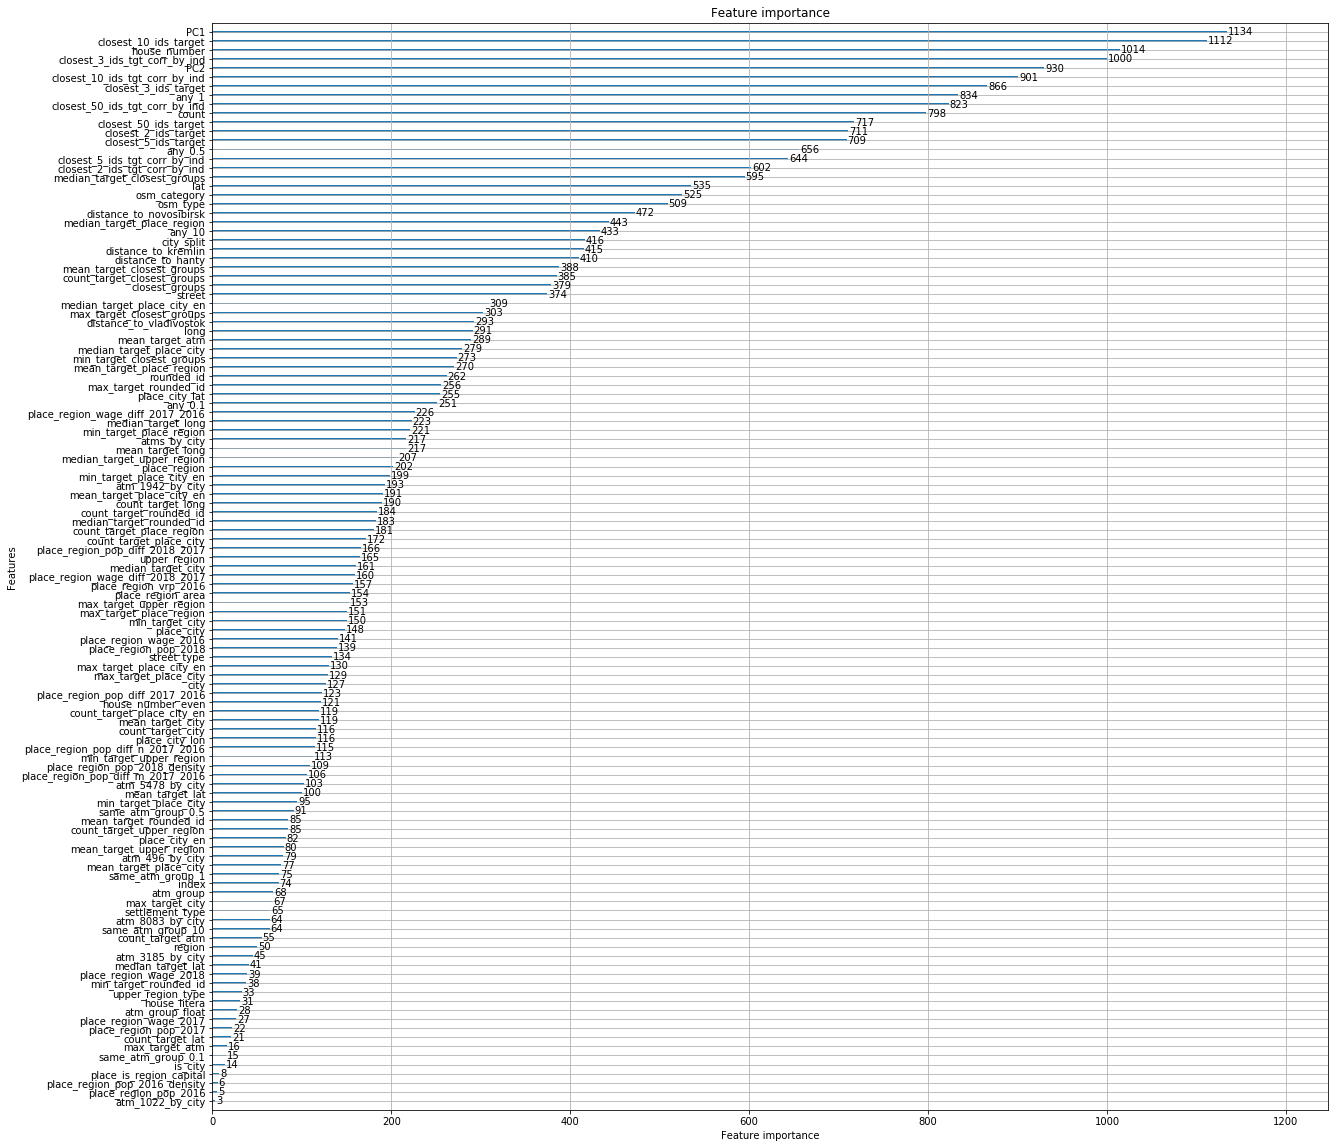

In [72]:
from sklearn.model_selection import RepeatedKFold, KFold
kf = RepeatedKFold(random_state=36851234, n_splits=5, n_repeats=20)
# kf = KFold(random_state=36851234, n_splits=5)
i = -1
for train_index, test_index in kf.split(X_):
    i += 1
    for function in [train_lgb, train_xgb, train_cat]:
        X_train, X_valid = X_.iloc[train_index], X_.iloc[test_index]
        Y_train, Y_valid = Y_.iloc[train_index], Y_.iloc[test_index]
        model, score = function(X_train, Y_train, X_valid, Y_valid)
        print(i, function, score)
        regression_models.append(model)
        scores.append(score)

In [72]:
predictions = []

In [73]:
for model_i, model in enumerate(regression_models):
    if (model_i + 1) % 3 == 0:
        valid_pool = Pool(X_valid_final)
        preds = model.predict(valid_pool)
    else:
        preds = model.predict(X_valid_final)
    predictions.append(preds)

In [74]:
predictions = np.array(predictions)

In [75]:
scores = 1 - np.array([rmse(Y_valid_final, p) for p in predictions])
scores = (scores - np.mean(scores)) / (np.max(scores) - np.mean(scores))
scores += abs(np.min(scores))
weights = scores
weights

array([1.4388576 , 0.98589826, 0.        , 1.55139023, 0.52920017,
       0.04513423, 1.94593822, 0.70711169, 1.22388288, 1.36267172,
       1.13849498, 0.40198866, 1.30686919, 1.2605212 , 0.29111434])

In [76]:
rmse(Y_valid_final, np.average(predictions, axis=0, weights=weights))

0.041460310732316485

In [ ]:
# empty_features = set([f[0] for f in feature_score[feature_score["Score"] == 0].values])
# try:
#     with open("empty_features") as file:
#         old_features = file.readlines()
#     old_features = set([f.strip() for f in old_features])
#     new_features = old_features | empty_features
# except FileNotFoundError:
#     new_features = empty_features
# with open("empty_features", "w") as file:
#     file.write("\n".join(new_features))

In [81]:
rmse(Y_valid, np.zeros(Y_valid.shape[0]))

0.08608459287735076

In [77]:
test_predictions = []
test_pool = Pool(X_test)
for model_i, model in enumerate(regression_models):
    if (model_i + 1) % 3 == 0:
        
        preds = model.predict(test_pool)
    else:
        preds = model.predict(X_test)
    test_predictions.append(preds)

In [78]:
submit = pd.DataFrame(
    np.average(test_predictions, axis=0, weights=weights),
    index=test.index, columns=['target'])
submit_cat = pd.DataFrame(
    np.mean([model.predict(test_pool) for model in regression_models[2::3]], axis=0),
    index=test.index, columns=['target'])
submit_gbm = pd.DataFrame(
    np.mean([gbm.predict(X_test) for gbm in regression_models[0::3]], axis=0),
    index=test.index, columns=['target'])
submit_xgb = pd.DataFrame(
    np.mean([xgb.predict(X_test) for xgb in regression_models[1::3]], axis=0),
    index=test.index, columns=['target'])

In [79]:
submit.to_csv('submit.csv')
submit_cat.to_csv("submit_cat.csv")
submit_gbm.to_csv("submit_gbm.csv")
submit_xgb.to_csv("submit_xgb.csv")

In [86]:
import pickle
pickle.dump(regression_models, open("regression_models_dec_20_{}.pcl".format(len(regression_models)), "wb"))

In [ ]:
# pd.DataFrame(X[["city", "address_rus"]].groupby(["city"]).describe())

In [ ]:
# f = lambda x: len(x.split()) > 2
# city = X[X["city"].apply(f)]
# city["city"]

In [ ]:
# addresses = X[X["lat"].isna()]["address"]
# addresses_index = addresses.index
# addresses = addresses.values
# addresses.shape

In [ ]:
# yandex_addresses = []
# for a_i, a in enumerate(addresses):
#     yandex_addresses.append(geocoder.yandex(a))

In [ ]:
# latitudes = X["lat"].values
# longitudes = X["long"].values
# reversed_addresses = dict()
# for a_i, a in enumerate(yandex_addresses):
#     print(a_i, end="\r")
#     if not a:
#         continue
#     if a.country != "Russia":
#         continue
#     latitudes[addresses_index[a_i]] = a.lat
#     longitudes[addresses_index[a_i]] = a.lng
#     reversed_addresses[addresses_index[a_i]] = geocoder.yandex([a.lat, a.lng], method='reverse')

In [ ]:
# import pickle
# pickle.dump(longitudes, open("longitudes.pcl", "wb"))

In [ ]:
# X.upper_region

In [ ]:
# X.groupby("place_region").count()

In [ ]:
regression_columns = [c for c in X.columns if "target" in c] + ["lat", "long"]
X_regression = X[regression_columns]
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.1)
X_train_reg = X_train[regression_columns]
X_valid_reg = X_valid[regression_columns]
clf.fit(X_train_reg, Y_train)

In [ ]:
split = kf.split(X_train)